/var/folders/9z/f33049_x6bs5y2xvclxp23j00000gn/T/ipykernel_75046/3079240102.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap('tab20')
/var/folders/9z/f33049_x6bs5y2xvclxp23j00000gn/T/ipykernel_75046/3079240102.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  extra = plt.cm.get_cmap('Set3')


{'EleutherAI': array([0.12156863, 0.46666667, 0.70588235, 1.        ]), 'Cerebras': array([0.68235294, 0.78039216, 0.90980392, 1.        ]), 'MBZUAI': array([1.        , 0.49803922, 0.05490196, 1.        ]), 'Microsoft': array([1.        , 0.73333333, 0.47058824, 1.        ]), 'StabilityAI': array([0.17254902, 0.62745098, 0.17254902, 1.        ]), 'Alibaba': array([0.59607843, 0.8745098 , 0.54117647, 1.        ]), 'TinyLlama': array([0.83921569, 0.15294118, 0.15686275, 1.        ]), 'Meituan': array([1.        , 0.59607843, 0.58823529, 1.        ]), 'Google': array([0.58039216, 0.40392157, 0.74117647, 1.        ]), 'H2O': array([0.77254902, 0.69019608, 0.83529412, 1.        ]), 'OpenBMB': array([0.54901961, 0.3372549 , 0.29411765, 1.        ]), 'Apple': array([0.76862745, 0.61176471, 0.58039216, 1.        ]), 'HuggingFace': array([0.89019608, 0.46666667, 0.76078431, 1.        ]), 'TensorOpera AI': array([0.96862745, 0.71372549, 0.82352941, 1.        ]), 'Toyota': array([0.49803922, 0.4

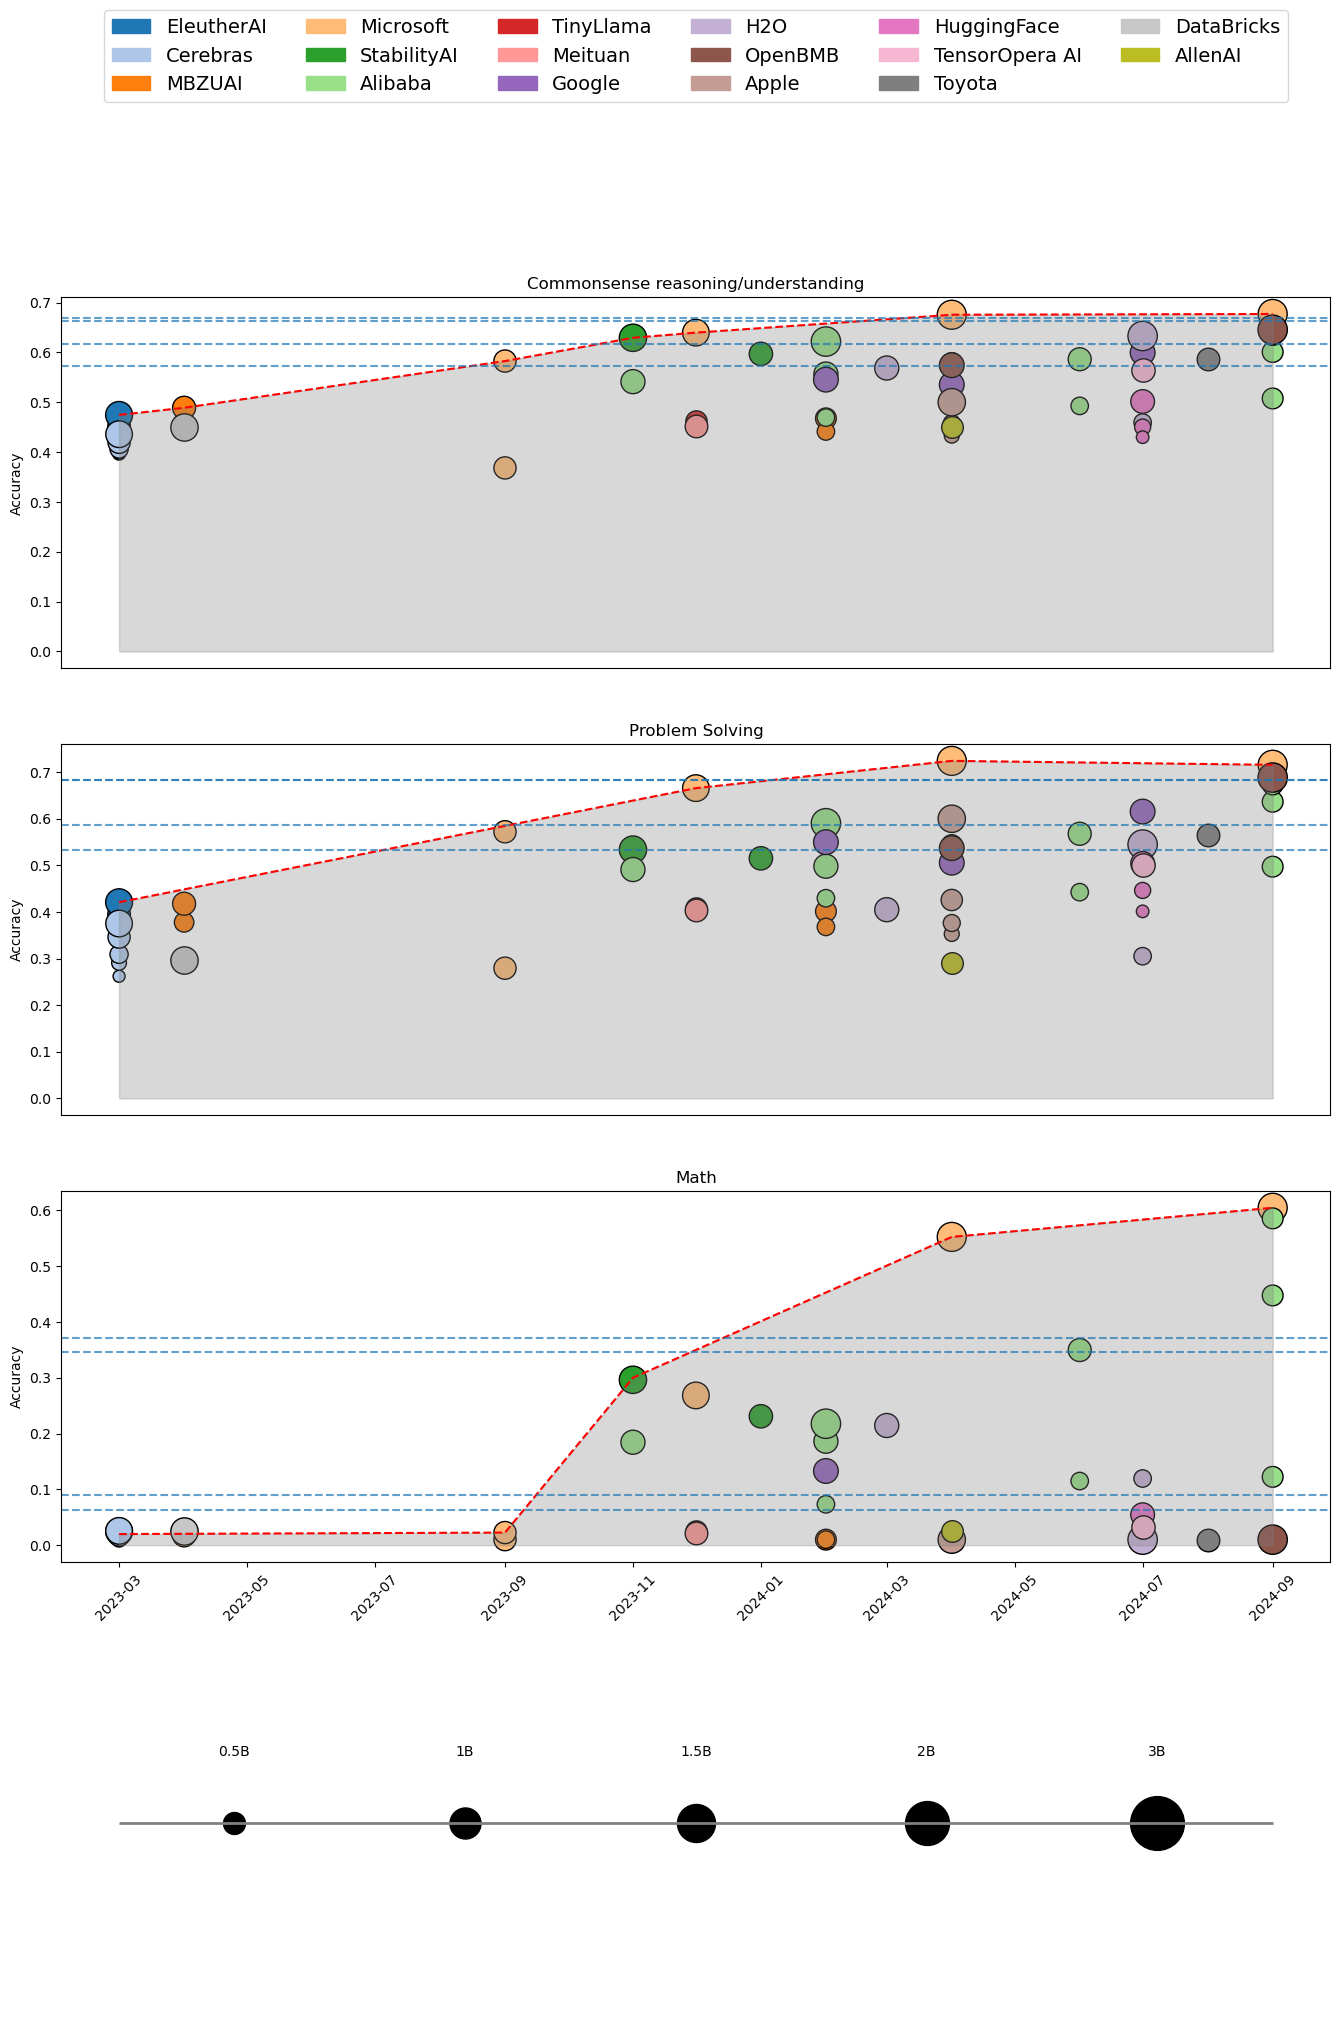

In [1]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
from pandas.errors import ParserError
from brokenaxes import brokenaxes
import math

# Load the CSV file
file_path = 'big-table.csv'
data = pd.read_csv(file_path)

# Helper function to handle mixed date formats
def parse_date(date_str):
    try:
        date_str = str(date_str)
        return pd.to_datetime(date_str, format='%Y.%m')
    except (ValueError, ParserError):
        try:
            return pd.to_datetime(date_str, format='%Y')
        except (ValueError, ParserError):
            return pd.NaT  # Return a NaT if the date format is unknown

# Convert metrics to numeric and fill NaNs with default values (e.g., 0)
data['Commonsense reasoning/understanding'] = pd.to_numeric(data['Commonsense reasoning/understanding'], errors='coerce').fillna(0.5)
data['Problem solving'] = pd.to_numeric(data['Problem solving'], errors='coerce').fillna(0.6)
data['Math'] = pd.to_numeric(data['Math'], errors='coerce').fillna(1)

# Fill NaNs in 'Parameters' with a default value (e.g., "1")
data['Parameters'] = data['Parameters'].fillna('1')

# Convert 'Parameters' to bilionbytes (B)
def convert_params_to_gigabytes(param_str):
    try:
        if 'M' in param_str:
            return float(param_str.replace('M', '')) / 1e3  # Convert M to B
        else:
            return float(param_str.replace('B', ''))  # If already in B, return as-is
    except ValueError:
        print("error")
        return 1  # Fallback in case of a parsing error

data['Parameters (G)'] = data['Parameters'].apply(convert_params_to_gigabytes)


# Apply the helper function to 'Release Date (Year.Month)'
data['Release Date (Year.Month)'] = data['Release Date (Year.Month)'].apply(parse_date)

# Find all the LLaMA models (assuming "llama" is in their name)
llama_models = data[data['Model'].str.startswith('Llama', na=False)]

# Remove rows with NaT in 'Release Date (Year.Month)'
data = data.dropna(subset=['Release Date (Year.Month)'])

# 只保留从2021年1月之后的数据
data = data[data['Release Date (Year.Month)'] >= pd.Timestamp('2023-01-01')]



# Set colors based on affiliation
data['affiliation'] = data['affiliation'].str.strip()
affiliations = data['affiliation'].unique()
# Create a larger colormap by repeating and mixing different colormaps
import numpy as np

# Generate a custom color map for 25 colors
def generate_color_map(n):
    base = plt.cm.get_cmap('tab20')
    extra = plt.cm.get_cmap('Set3')
    color_list = list(base(np.linspace(0, 1, 20)))  # 20 colors from 'tab20'
    if n > 20:
        extra_colors = list(extra(np.linspace(0, 1, n - 20)))  # Remaining colors from 'Set3'
        color_list.extend(extra_colors)
    return color_list[:n]

colors = generate_color_map(len(affiliations))
affiliation_color_map = {affiliation: colors[i] for i, affiliation in enumerate(affiliations)}

print(affiliation_color_map)

llama_family = ['LLaMA 1 (7B)', 'LLaMA 2 (7B)', 'LLaMA 3 (7B)', 'LLaMA 3.1 (7B)']
# Plotting
plt.figure(figsize=(14, 20))

# data = data[data['affiliation'] != "Apple"]
# Plot 1: Commonsense reasoning/understanding over time
plt.subplot(4, 1, 1)
highest_values = []
for affiliation in affiliations:
    subset = data[data['affiliation'] == affiliation]
    plt.scatter(subset['Release Date (Year.Month)'], subset['Commonsense reasoning/understanding'], 
                s=numpy.sqrt(subset['Parameters (G)']*50000), c=[affiliation_color_map[affiliation]], 
                edgecolors='k', label=affiliation)
    
   # Track the highest value for each date
    for date in subset['Release Date (Year.Month)'].unique():
        highest_value = subset[subset['Release Date (Year.Month)'] == date]['Commonsense reasoning/understanding'].max()
        highest_values.append((date, highest_value))
        print(date, highest_values)

# Convert list of tuples to a sorted DataFrame
highest_df = pd.DataFrame(highest_values, columns=['Date', 'Max Value']).drop_duplicates('Date').sort_values('Date')

# 指定时间戳和新值
timestamp_to_replace = pd.Timestamp('2024-02-01 00:00:00')
new_value = 0.5898431176054166

# 查找并替换对应时间的值
highest_df.loc[highest_df['Date'] == timestamp_to_replace, 'Max Value'] = new_value

new = highest_df.iloc[-1]
print(new)
# 只保留上升的值
highest_df = highest_df[highest_df['Max Value'].cummax() == highest_df['Max Value']]
# 添加最后一个new
highest_df.loc[len(highest_df)] = new
highest_df = highest_df.drop_duplicates('Date').sort_values('Date')

print(highest_df)
# 确认结果
# print(highest_df)
# Plot the line connecting the highest points
plt.plot(highest_df['Date'], highest_df['Max Value'], color='red', linestyle='--')

# Fill between the highest points and the x-axis
plt.fill_between(highest_df['Date'], highest_df['Max Value'], 0, color='gray', alpha=0.3)

    
for i, (_, llama) in enumerate(llama_models.iterrows()):
    plt.axhline(y=llama['Commonsense reasoning/understanding'], linestyle='--', alpha=0.7)

plt.title('Commonsense reasoning/understanding')
plt.ylabel('Accuracy')
plt.xticks([])
# Custom Legend with smaller circles
from matplotlib.patches import Patch
legend_patches = [Patch(color=affiliation_color_map[affiliation], label=affiliation) for affiliation in affiliations]
plt.legend(handles=legend_patches, loc='upper center', bbox_to_anchor=(0.5, 1.8), ncol=6, fontsize=14)

highest_values = []
# Plot 2: Problem solving over time
plt.subplot(4, 1, 2)
for affiliation in affiliations:
    subset = data[data['affiliation'] == affiliation]
    plt.scatter(subset['Release Date (Year.Month)'], subset['Problem solving'], 
                s=numpy.sqrt(subset['Parameters (G)']*50000), c=[affiliation_color_map[affiliation]], 
                edgecolors='k')

    # Track the highest value for each date
    for date in subset['Release Date (Year.Month)'].unique():
        highest_value = subset[subset['Release Date (Year.Month)'] == date]['Problem solving'].max()
        highest_values.append((date, highest_value))
        print(date, highest_values)

# Convert list of tuples to a sorted DataFrame
highest_df = pd.DataFrame(highest_values, columns=['Date', 'Max Value']).drop_duplicates('Date').sort_values('Date')

# 指定时间戳和新值
timestamp_to_replace = pd.Timestamp('2024-02-01 00:00:00')
new_value = 0.5898431176054166

# 查找并替换对应时间的值
highest_df.loc[highest_df['Date'] == timestamp_to_replace, 'Max Value'] = new_value

new = highest_df.iloc[-1]
print(new)
# 只保留上升的值
highest_df = highest_df[highest_df['Max Value'].cummax() == highest_df['Max Value']]
# 添加最后一个new
highest_df.loc[len(highest_df)] = new
highest_df = highest_df.drop_duplicates('Date').sort_values('Date')

print(highest_df)
# 确认结果
# print(highest_df)
# Plot the line connecting the highest points
plt.plot(highest_df['Date'], highest_df['Max Value'], color='red', linestyle='--')

# Fill between the highest points and the x-axis
plt.fill_between(highest_df['Date'], highest_df['Max Value'], 0, color='gray', alpha=0.3)


for i, (_, llama) in enumerate(llama_models.iterrows()):
    plt.axhline(y=llama['Problem solving'], linestyle='--', alpha=0.7)

plt.title('Problem Solving')
plt.ylabel('Accuracy')
plt.xticks([])

# Plot 3: Math over time
highest_values = []
plt.subplot(4, 1, 3)
x_offsets = [0, 0, 0, 0]  # List of offsets to avoid overlapping
y_offsets = np.array([-0.08, 0, -0.04, 0.05])*50  # List of offsets to avoid overlapping
for affiliation in affiliations:
    subset = data[data['affiliation'] == affiliation]
    plt.scatter(subset['Release Date (Year.Month)'], subset['Math']/100, 
                s=numpy.sqrt(subset['Parameters (G)']*50000), c=[affiliation_color_map[affiliation]], 
                edgecolors='k')
                

   # Track the highest value for each date
    for date in subset['Release Date (Year.Month)'].unique():
        highest_value = subset[subset['Release Date (Year.Month)'] == date]['Math'].max()
        highest_values.append((date, highest_value))
        print(date, highest_values)

# Convert list of tuples to a sorted DataFrame
highest_df = pd.DataFrame(highest_values, columns=['Date', 'Max Value']).drop_duplicates('Date').sort_values('Date')

# # 指定时间戳和新值
timestamp_to_replace = pd.Timestamp('2023-03-01 00:00:00')
new_value = 2

# 查找并替换对应时间的值
highest_df.loc[highest_df['Date'] == timestamp_to_replace, 'Max Value'] = new_value


# # 指定时间戳和新值
timestamp_to_replace = pd.Timestamp('2023-11-01 00:00:00')
new_value = 30

# 查找并替换对应时间的值
highest_df.loc[highest_df['Date'] == timestamp_to_replace, 'Max Value'] = new_value

new = highest_df.iloc[-1]
print(new)
# 只保留上升的值
highest_df = highest_df[highest_df['Max Value'].cummax() == highest_df['Max Value']]
# 添加最后一个new
highest_df.loc[len(highest_df)] = new
highest_df = highest_df.drop_duplicates('Date').sort_values('Date')

print(highest_df)
# 确认结果
# print(highest_df)
# Plot the line connecting the highest points
plt.plot(highest_df['Date'], highest_df['Max Value']/100, color='red', linestyle='--')

# Fill between the highest points and the x-axis
plt.fill_between(highest_df['Date'], highest_df['Max Value']/100, 0, color='gray', alpha=0.3)

for i, (_, llama) in enumerate(llama_models.iterrows()):
    plt.axhline(y=llama['Math']/100, linestyle='--', alpha=0.7)

plt.title('Math')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

plt.subplot(4, 1, 4)

# Key parameter sizes to label
key_sizes = [0.5, 1, 1.5, 2, 3]  # Sizes in Billion

# Normalize the x positions for even spacing
x_positions = np.linspace(0.1, 0.9, len(sorted(key_sizes)))

# Plot a horizontal line
plt.hlines(y=1, xmin=0, xmax=1, colors='gray', linewidth=2)

# Scatter plot for the selected parameter sizes
for i, size in enumerate(sorted(key_sizes)):
    plt.scatter(x_positions[i], 1, s=size*500, color='k', edgecolors='k')
    plt.text(x_positions[i], 1.02, f"{size}B", horizontalalignment='center')

# Remove the borders (spines)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# plt.title('Parameters Size Representation')
plt.yticks([])
plt.xticks([])

plt.tight_layout()
plt.savefig('../figs/acc-evolution.pdf', bbox_inches='tight')
plt.show()
